In [1]:
import os, sys
from pathlib import Path
script_dir = Path(os.path.dirname(os.path.abspath('')))
module_dir = str(script_dir)
sys.path.insert(0, module_dir + '/modules')
print(module_dir)

# import the rest of the modules
import numpy as np
import tensorflow as tf 
import matplotlib.pyplot as plt
import arch
import pandas as pd
import tensorflow_probability as tfp
import time  
import sim  

DTYPE = 'float32'

# define parameters for L63 system
dim = 4
sigma = 0.1

# define parameters for simlulation
n_particles = int(1e6)
n_subdivisions = 30
save_folder = '../data'
n_steps = 50
n_repeats = 10
dt = 0.1
r = 1.0

def mu_tf(X):
    x, y, x1, y1 = tf.split(X, dim, axis=-1)
    z = 4. * (x*x + y*y - 1.0)
    z1 = 4. * (x1*x1 + y1*y1 - 1.0)
    return tf.concat([-x*z, -y*z, -x1*z1, -y1*z1], axis=-1) 

mu_np = lambda X: mu_tf(X).numpy()

C:\Users\pinak\Documents\GitHub\sphere-fp


Time taken by propagate is 0.2931375503540039 seconds
Time taken by compile is 2.6934497356414795 seconds


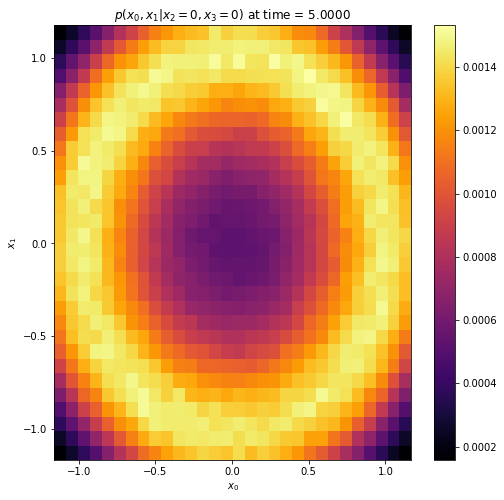

In [3]:
net = arch.LSTMForgetNet(50, 3, tf.float32, name="sphere4D")
net.load_weights('../data/4D/{}'.format(net.name)).expect_partial()

@tf.function
def h_mu(X):
    p, q, p1, q1 = tf.split(mu_tf(X), dim, axis=-1)
    x, y, x1, y1 = tf.split(X, dim, axis=-1)
    with tf.GradientTape() as tape:
        tape.watch([x, y, x1, y1])
        n_theta = net(x, y, x1, y1)
    a, b, c, d = tape.gradient(n_theta, [x, y, x1, y1])
    return tf.concat([a*sigma**2 - p, b*sigma**2 - q, c*sigma**2 - p1, d*sigma**2 - q1], axis=-1)





# define h0
r = 1.
def h0(X):
#     print(X)
    x_, y_, x1_, y1_ = tf.split(X, dim, axis=-1)
    log_p0 = (- tf.reduce_sum(X**2, axis=-1) / (2.*r**2)).numpy()
    log_pinf = net(x_, y_, x1_, y1_).numpy().flatten()
    return np.exp(log_p0 - log_pinf) / (2. * np.pi * r**2)**2 


# Feynman-Kac simulation
X0 =  tfp.distributions.MultivariateNormalDiag(scale_diag=tf.ones(dim)*r).sample(n_particles).numpy()
mc_prob = sim.MCProb(save_folder, n_subdivisions, mu_np, sigma, X0)
# mc_prob.ready(n_steps=n_steps, dt=dt, lims=None)
# mc_prob.slice2D(dims=[1, 0], levels={3: 0., 2: 0.}, eps=.5)
# mc_prob.slice2D(dims=[0, 1], levels={2: 0.})
# mc_prob.slice2D(dims=[2, 0], levels={1: 0.})
fk_sim = sim.FKSlice2(save_folder, n_subdivisions, mu_tf, sigma, net, grid=mc_prob.get_grid(), h0=h0, dim=dim)
fk_sim.propagate(n_steps, dt, n_repeats, levels={2:0, 3:0})
fk_sim.compile(n_repeats, levels={2:0, 3:0})

In [ ]:
X0 =  tfp.distributions.MultivariateNormalDiag(scale_diag=tf.ones(dim)*r).sample(n_particles).numpy()
X0

In [ ]:
mc_prob.get_grid().maxs, mc_prob.get_grid().mins

In [ ]:
sorted(set(range(3)) - set({2:0, 3:0}))

In [ ]:
set({2:0, 3:0}), set()